<a href="https://colab.research.google.com/github/LukasBeckers/Transformer_Image_Completion/blob/main/Transformer%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports

from google.colab.patches import cv2_imshow
from tensorflow.keras import layers
from glob import glob, escape
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle as pk
import numpy as np
import random
import time
import cv2
import os

In [2]:
# Checking if a GPU is available on the system.

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15124073712150591840
xla_global_id: -1
]


In [3]:
# Checking the current directory.

!pwd

/content


In [4]:
# Connecting the notebook to your google-drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
"""
First all file-paths are loaded and stored into a list.
This is done by the 'load_data' function.
"""

def load_data(folder):
  """
  This function returns all jpeg-files that are in the path, 
  which is given as 'folder' parameter.
  
  :param folder:  str: Path to the folder, 
                       in which the jpeg-images of the dataset are stored.
                       
  :return:       list: List with paths to all the jpeg-files of the folder. 
                       The paths are returned as strings."""

  files = glob(f'{folder}/*.jpeg')
  return files

folder = '/content/drive/MyDrive/Colab Notebooks/Transformer_Image_Completion/imagenet_r'
files = load_data(folder)

print(f'Example file: {files[0]}')
print(f'Number of jpeg-files: {len(files)}')


Example file: /content/drive/MyDrive/Colab Notebooks/Transformer_Image_Completion/imagenet_r/29000_375_500_292.jpeg
Number of jpeg-files: 30000


In [9]:


def read_image(image_path):
    '''
    This function takes a path to an image as argument and returns the image as 
    numpy array.

    :param image_path: string: Path to the image-file

    :return:           numpy array: Image loaded as numpy array.
    '''
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    return image.astype(np.float32)

Text(0.5, 1.0, 'Test Image')

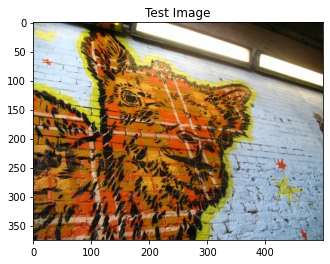

In [11]:
# Testing and Debugging


# Loading the image.
test_image = read_image(files[0])

# Plotting the image.
plt.imshow(test_image/255)
plt.title('Test Image')

In [12]:
"""
For this project I decided to use a self-coded transformer model. 
A is advantageous for this dataset, because a vision-transformer 
can handel images of different size natively. In contrast to that, more typical 
computer-vision networks, like Res- or Reg-nets need images 
with an consitant format. 

A transformer network transforms each token of a sequence of tokens individually.
A realation between the tokens is created in a transformer networks via Multihead-self-attention.
For this reason each image must be converted to a sequence of vectors. 
This is done by splitting the images into smaller segments.
"""

def split_image(image, segment_width):
    '''
    This function crops the image, so that the width and the hight of the image 
    are devisible by the 'segment_width' parameter. 
    The cropped image is split into square-segments in the size of the 'segment_width'.

    :param image:           RGB-image (tf-tensor or np.array) of shape[higth, width, RGB]
    :param segment_width:   Width of the segments-squares that the image will be split into

    :return:                tf-tensor of shape[hight//segment_width, width//segment_width, segment_width, segment_width, RGB].
                            If the image width or hight is not devisable by the segment_width, it will be cropped.
    '''
    # Cropping the image
    image = image[:image.shape[0] // segment_width * segment_width]   # Cropping height
    image = image[:,:image.shape[1] // segment_width * segment_width] # Cropping width
    # Splitting the image.
    # First the width is split, then the hight of the image is split.
    image = tf.reshape(image, [image.shape[0],                        # height
                               image.shape[1]//segment_width,         # N_width_segments
                               segment_width,                         # segment_width
                               image.shape[2]                         # RGB
                               ])
    image = tf.transpose(image, [1, 0, 2, 3])                         # Swapping height and N_width_segments
    image = tf.reshape(image, [image.shape[0],                        # N_width_segments
                               image.shape[1]//segment_width,         # N_height_segments
                               segment_width,                         # segment_width
                               segment_width,                         # segment_width
                               image.shape[3]                         # RGB
                               ])
    image = tf.transpose(image, [1, 0, 2, 3, 4])                      # Swapping N_width_segments and N_height_segments
    # Output shape: [N_height_segments, N_width_segments, segment_width, segment_width, RGB]
    return image


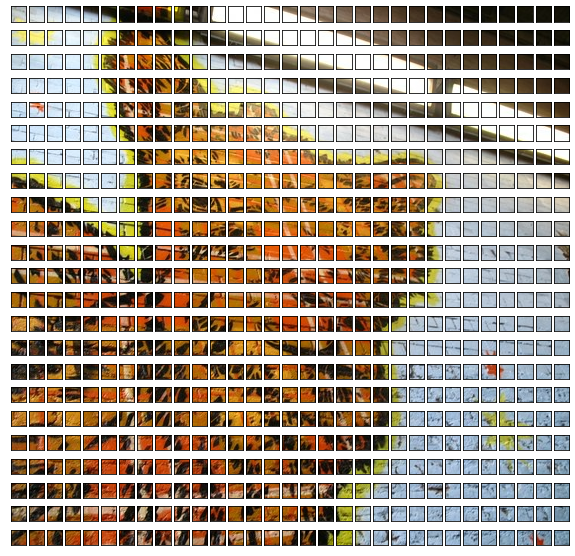

In [17]:
# Testing and Debugging

# Splitting the image.

segment_width = 16
split_test_image = split_image(test_image, segment_width)

# Plotting the split-test-image.
ig, axs = plt.subplots(test_image.shape[0]//segment_width,
                           test_image.shape[1]//segment_width,
                           figsize=[10, 10])

for i_row_g, row_g  in enumerate(axs):
    for i_col_g, col_g in enumerate(row_g):
        col_g.imshow(split_test_image[i_row_g, i_col_g]/255)

        # Removing the number on the axis
        col_g.set_xticks([])
        col_g.set_yticks([])


In [18]:
"""
The output of the transformer-model will also have the shape of a split-image.
For this reason, a function to reverse the split process is needed.
"""

def unsplit_image(image):
    '''
    This function reverses the split_image function (except the cropping).

    :param image:           split RGB-image tf-tensor of shape[N_height_segments, N_width_segments, segment_width, segment_width, RGB]

    :return:                RGB-image-batch tf-tensor of shape[N_images, heigth, width, RGB]
    '''
    image = tf.transpose(image, [1, 0, 2, 3, 4])                      # Swapping N_width_segments and N_height_segments
    image = tf.reshape(image, [image.shape[0],                        # N_width_segments
                               image.shape[1]*image.shape[2],         # N_hight_segments * segment_width = height
                               image.shape[3],                        # segment_width
                               image.shape[4]                         # RGB
                               ])
    image = tf.transpose(image, [1, 0, 2, 3])                         # Swapping height and N_width_segments
    image = tf.reshape(image, [image.shape[0],                        # height
                               image.shape[1]*image.shape[2],         # N_width_segments * segment_width = width
                               image.shape[3]                         # RGB
                               ])
    return image

Text(0.5, 1.0, 'Unsplit Image')

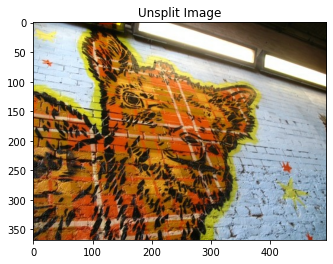

In [20]:
# Testing and Debugging

# Unsplitting the test image.
unsplit_test_image = unsplit_image(split_test_image)

# Plotting the unsplit test image.
plt.imshow(unsplit_test_image/255)
plt.title('Unsplit Image')

In [22]:
"""
The envisioned transformer model will transform each segment of the image individually.
The model will then attend between the transformed tokens via multiheadattention.
All these steps are not influenced by the order of the image segments in the sequence.
This is unwanted for processing an image, because the order 
of the image-segments obviously matters a lot in a picture.
For this reason to each image-semgent a vector is added, 
which encodes the position of this semgent in the context of the whole image.

Positional Encoding as described in the paper "Attention is all you need"
Doi: arXiv:1706.03762v5 [cs.CL] 6 Dec 2017
"""

class PositionalEncoding():
    '''
    Creates an PositionalEncoding object, with defined maximum sequence length and encoding dimension.
    (for max_length = 100 and encoding_dimension = 256)
    '''
    def __init__(self, max_length, encoding_dimension):
        '''
        :param max_length:           Maximum position that can be meening-fully encoded.

        :param encoding_dimension:   Dimension of the encoded positions.
                                     This parameter should match the encoding dimension of the transformer model, that is used.
        '''
        self.max_length = max_length                    # Highest encoded position.
        self.encoding_dimension = encoding_dimension    # Output dimension of the positional encoding vector

    def __call__(self, positions):
        '''
        :param positions: An array of positions to encode.
                          All positions should be in form of ints.
                          Example: positions=[0, 1, 3] would return a tensor of shape [3, encoding_dimension]
                          with the encoded positions 0, 1, 3.
        :return:          Tensorflow Tensor of shape [N_positons, encoding_dimension]
        '''
        encoded_positions = np.full([len(positions), self.encoding_dimension],  # 2D np.array of shape [N_positions, encoding_dimensions]
                                    tf.range(self.encoding_dimension),          # filled with numbers from 0...(encoding_dimension-1)
                                    dtype=np.float32)
        encoded_positions = encoded_positions//2                                # all elements of array floor-devided by two
        encoded_positions = self.max_length**(-2
                                              *encoded_positions
                                              /self.encoding_dimension)
        positions_array = np.full([self.encoding_dimension,
                                   len(positions)],
                                  positions)

        positions_array = np.swapaxes(positions_array, 0, 1)
        encoded_positions = encoded_positions * positions_array
        encoded_positions[::2] += np.pi/2                                       # Adding Pi/2 to every odd row, so that sin = cos for odd rows.
        encoded_positions = np.sin(encoded_positions)                           # Calling the sinus function on each element in the array.
        encoded_positions = tf.convert_to_tensor(encoded_positions,             # Converting output to tensorflow tensor.
                                                 dtype=tf.float32)
        return encoded_positions

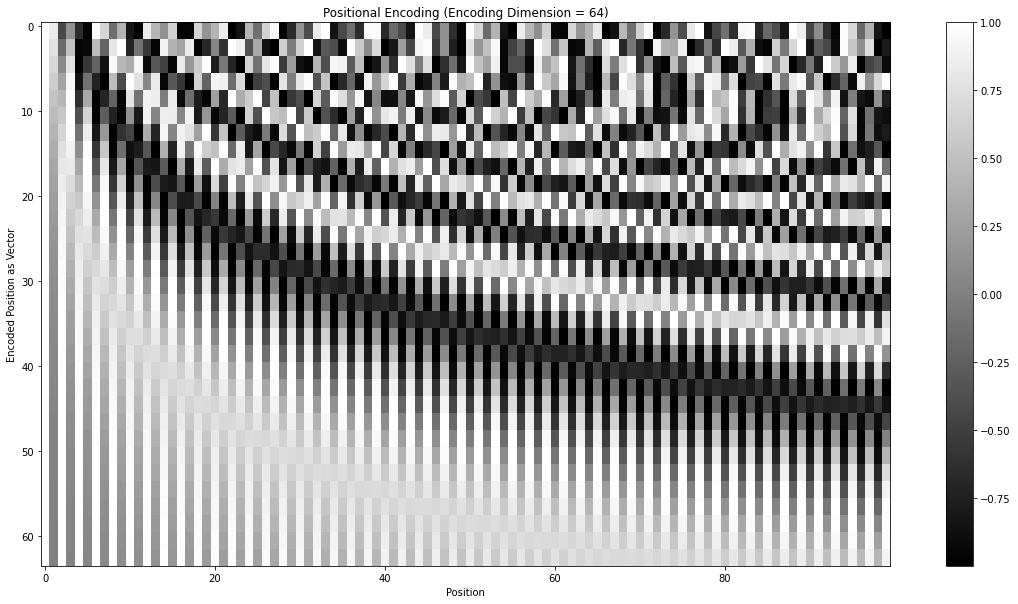

In [26]:
# Testing and Debugging
# Shows the encoded-vectors for 100 successive positions (max_length = 100, encoding_dimension = 64)

max_length = 100
encoding_dimension = 64
n_positions = 100

# Generating the encodings.
test_positional_encoder = PositionalEncoding(max_length, encoding_dimension)
encoded_positions = test_positional_encoder([i for i in range(n_positions)])
image_encoded_positions = tf.transpose(encoded_positions, [1, 0])

# Plotting the Encodings.
fig, axs = plt.subplots(1, figsize=[20, 10])
im = axs.imshow(image_encoded_positions, cmap='gray')
axs.set_xlabel('Position')
axs.set_ylabel('Encoded Position as Vector')
axs.set_title(f'Positional Encoding (Encoding Dimension = {encoding_dimension})')
plt.colorbar(im)
plt.show()

In [24]:
def image_positions_encoding(split_image, positional_encoding):
    '''
    This function creates positional-encoding vectors for each segment-position. 
    Separate vectors for the heigth and the width postion in the image are created.
    in the image.

    :param split_image:               (tf tensor): Image split by split_image function.
                                Shape = [N_height_segments, N_width_segments, segment_width, segment_width, RGB]
    :param positional_encoding: (function or callable object): Function or object that encodes a list of positions into vectors.

    :return:                    (tuple of tf.tensor): Height positions and width positions for each image segment created by the positional_encoding function.
    '''
    n_hight_segments = split_image.shape[0]
    n_width_segments = split_image.shape[1]
    # encoding the 'row/hight' positions for each image-segment.
    hight_positions = positional_encoding([i for i in range(n_hight_segments)])
    hight_positions = tf.stack([hight_positions for _ in range(n_width_segments)], axis=0)
    hight_positions = tf.transpose(hight_positions, [1, 0, 2])
    # encoding the 'col/width' positons for each image-segment.
    width_position = positional_encoding([i for i in range(n_width_segments)])
    width_position = tf.stack([width_position for _ in range(n_hight_segments)])

    return hight_positions, width_position

def add_position(split_image, positional_encoding):
    '''
    Creates positional encodings for a split image and adds them to the segments.
    :param image:               (tf.tensor): Image split by split image function
    :param positional_encoding: (function or callable object): Function or object that encodes a list of positions into vectors.

    :return:                    (tf.tensor): Split image with the positional encodings added to the segments.
    '''
    # Creating the positional encodings
    hight_positions, width_positions = image_positions_encoding(split_image, positional_encoding)
    # adding the positional encodings to the image.
    split_image = split_image + tf.reshape(hight_positions, split_image.shape) + tf.reshape(width_positions, split_image.shape)
    return split_image

(23, 31, 16, 16, 3)


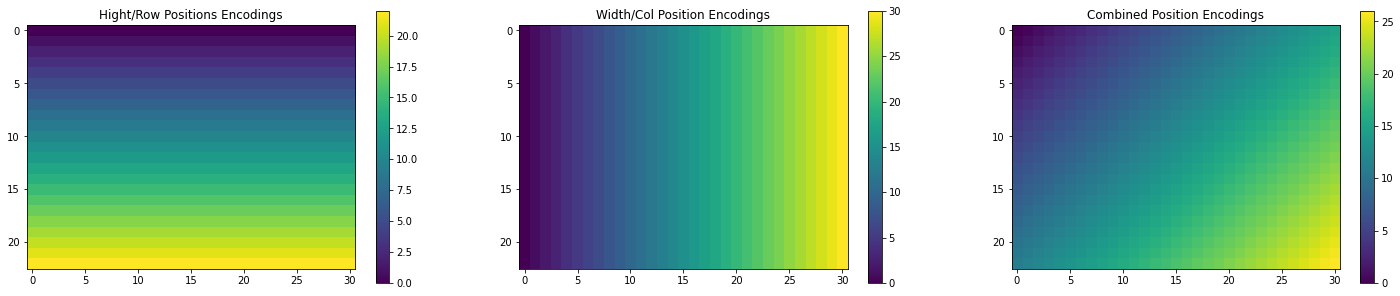

'Please Note when the real encoding algorithm is used and the positonal encodings are added, there will be no positon duplicates (because every position is a unique vector), unlike in this simplified case.'

In [32]:
# Testing and Debugging

# Creating a simple test positional encoding function.
# (returns the position as a number)
def debugging_pos_encoding(positions):
    '''
    Simple function for debugging purposes, that returns the positions-number as tensor.
    Pos 0 = int(0)
    Pos 1 = int(1) etc.

    :param positions:   list of ints. Positions to encode
    :return:            tf tensor of shape [N_positions, 1]
    '''
    return tf.constant([[pos] for pos in positions])

# creating the positonal encoding vectors.
hight_positions, width_positions = image_positions_encoding(split_test_image, positional_encoding=debugging_pos_encoding)
print(split_test_image.shape)

# Plotting the vectors combined to the shape of the split-image.
fig, axs = plt.subplots(1, 3, figsize=[25, 5])
im = axs[0].imshow(hight_positions[:,:,0])
axs[0].set_title('Hight/Row Positions Encodings')
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(width_positions[:,:,0])
axs[1].set_title('Width/Col Position Encodings')
plt.colorbar(im, ax=axs[1])
im = axs[2].imshow(((width_positions+hight_positions)/2)[:,:,0])
axs[2].set_title('Combined Position Encodings')
plt.colorbar(im, ax=axs[2])
plt.show()
'''Please Note when the real encoding algorithm is used and the positonal encodings are added, there will be no positon duplicates (because every position is a unique vector), unlike in this simplified case.'''

In [ ]:
def preprocess(image, mask):
    '''
    :param image:           string. Path to the image-file
    :param mask:            string. Path to the mask-file

    :return:                tf tensors. split-Image as tf tensor and mask as tf tensor.
    '''
    def load(image, mask):
        image, mask = image.decode(), mask.decode()    # Cleaning up the format
        image = read_image(image)                      # Loading the image
        image /= 255                                   # Scaling the image between 0 and 1
        mask = read_mask(mask)                         # Loading the mask
        mask /= 255                                    # Scaling the mask between 0 and 1
        return image, mask

    image, mask = tf.numpy_function(load, [image, mask], [tf.float32, tf.float32])   # Expected output -- tf tensor with dtype=float32
    return image, mask


def tf_dataset(images, masks, positional_encoding, batch_size=100, segment_width=16):
    '''
    :param images:                  (list of strings): List of paths to the image files
    :param masks:                   (list of strings): List of paths to the mask files
    :param positional_encoding:     (function): Funktion wich creates the positional encodings for a split image
    :param batch_size:              (int): Number of samples per batch
    :param segment_width:           (int): Segment-width by which the images will be split by the split_image function

    :return:                        (tfds): Tensorflow dataset. Each batch contains in the following order
                                            the images, masks, hight_positional_encodings, width_positional_encodings
    '''
    def split_image_wrapper(image, mask):
        image = tf.numpy_function(split_image, [image, segment_width], tf.float32)
        return image, mask

    def positons_wrapper(image, mask):
        def wrapper(image, pos_encoding=positional_encoding, function=add_position):
            image = function(image, pos_encoding)
            return image

        image = tf.numpy_function(wrapper, [image], tf.float32)
        return image, mask

    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.map(preprocess)
    dataset = dataset.map(split_image_wrapper)
    dataset = dataset.map(positons_wrapper)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(1)
    return dataset


max_length_g = 8
segment_width_g = 16
encoding_dimension_g = segment_width_g**2*3    # segment_width_g * segment_width_g * RGB
# Creating a positional-encoder with the encoding dimension = number of pixels in image segment.
positional_encoder_g = PositionalEncoding(max_length_g, encoding_dimension_g)
# Creating a tensorflow dataset (tfds) with all datapoints.
batch_size_g = 50
dataset_g = tf_dataset(images_g, masks_g, positional_encoder_g, batch_size=batch_size_g, segment_width=segment_width_g)

NameError: ignored